# Cahart Factor Model #

### The Model Specification ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data
from functions import import_stock_universe
from capm_toolkit import wexp
from capm_toolkit import compute_daily_returns
from capm_toolkit import compute_excess_returns
from capm_toolkit import capm_regression

In [2]:
# Get Data from Stock

ticker = 'META'

stock_price = import_financial_data(ticker)
stock_returns = stock_price['adj_close'].pct_change(1).dropna()

stock_returns

Date
2015-01-05   -0.016061
2015-01-06   -0.013473
2015-01-07    0.000000
2015-01-08    0.026592
2015-01-09   -0.005564
                ...   
2024-10-22    0.011910
2024-10-23   -0.031477
2024-10-24    0.007256
2024-10-25    0.009634
2024-10-28    0.008565
Name: adj_close, Length: 2471, dtype: float64

In [3]:
# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500
sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the SMB Premium
SMB = pd.read_csv(r"..\additional_data\famafrench_smb.csv")
SMB = SMB.set_index('Date')
SMB.index = pd.to_datetime(SMB.index)

# Get the data for the HML Premium
HML = pd.read_csv(r"..\additional_data\famafrench_hml.csv")
HML = HML.set_index('Date')
HML.index = pd.to_datetime(HML.index)

# Get the data for the WML Premium
WML = pd.read_csv(r"..\additional_data\carhart_wml.csv")
WML = WML.rename(columns={'Unnamed: 0':'Date'})
WML = WML.set_index('Date')
WML.index = pd.to_datetime(WML.index)

# Get the data for the HML Premium
BAB = pd.read_csv(r"..\additional_data\carhart_bab.csv")
BAB = BAB.rename(columns={'Unnamed: 0':'Date'})
BAB = BAB.set_index('Date')
BAB.index = pd.to_datetime(BAB.index)

In [4]:
# Create the data
daily_rfr = compute_daily_returns(rfr['risk_free_rate'])
market_excess_returns = compute_excess_returns(sp500['sp_500'], rfr['risk_free_rate'])
stock_excess_returns = stock_returns - daily_rfr

In [5]:
# Create the regression dataframe
regression_df = pd.DataFrame(index = stock_excess_returns.index)

regression_df['stock_excess_returns'] = stock_excess_returns
regression_df['MKT'] = market_excess_returns
regression_df['SMB'] = SMB
regression_df['HML'] = HML
regression_df['WML'] = WML
regression_df['BAB'] = BAB
regression_df.dropna(inplace = True)

regression_df

,stock_excess_returns,MKT,SMB,HML,WML,BAB
Date,,,,,,
2016-01-06,0.002276,-0.013175,-0.005512,-0.011682,0.021929,-0.020287
2016-01-07,-0.049103,-0.023760,-0.002765,-0.002323,0.011739,-0.020179
2016-01-08,-0.006084,-0.010897,-0.001349,0.000426,-0.000524,-0.009023
2016-01-11,0.001790,0.000794,-0.007499,-0.007483,0.013164,-0.009260
2016-01-12,0.019017,0.007745,-0.004479,-0.007502,0.009442,0.001620
...,...,...,...,...,...,...
2024-10-21,-0.002386,-0.001937,-0.000437,-0.007565,0.003078,-0.001216
2024-10-22,0.011795,-0.000589,-0.005932,0.004081,0.000943,-0.005778
2024-10-23,-0.031592,-0.009307,0.000967,0.005278,0.005427,-0.009356


In [6]:
# Create the Y Vector
y = regression_df['stock_excess_returns']

# Create the X Matrix
x = regression_df[['MKT', 'SMB', 'HML', 'WML', 'BAB']]

In [7]:
# Correlations

x.corr()

,MKT,SMB,HML,WML,BAB
MKT,1.000000,0.261294,0.053593,-0.213078,0.687643
SMB,0.261294,1.000000,0.341049,-0.509916,0.574578
HML,0.053593,0.341049,1.000000,-0.570186,0.218026
WML,-0.213078,-0.509916,-0.570186,1.000000,-0.426264
BAB,0.687643,0.574578,0.218026,-0.426264,1.000000


In [8]:
# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                             
Dep. Variable:     stock_excess_returns   R-squared:                       0.433
Model:                              WLS   Adj. R-squared:                  0.432
Method:                   Least Squares   F-statistic:                     335.1
Date:                  Tue, 22 Apr 2025   Prob (F-statistic):          3.15e-267
Time:                          13:32:46   Log-Likelihood:                 5462.5
No. Observations:                  2202   AIC:                        -1.091e+04
Df Residuals:                      2196   BIC:                        -1.088e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000

### Checking for Collinearity ###

In [9]:
vif_data = pd.DataFrame()
vif_data['vars'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

vif_data

,vars,VIF
0,MKT,2.014262
1,SMB,1.792368
2,HML,1.514850
3,WML,1.856133
4,BAB,2.860104


In [10]:
r_squared_df = pd.DataFrame()
r_squared_df['vars'] = x.columns

r_squared_df['r_squared'] = 1 - (1 / vif_data['VIF'])

r_squared_df

,vars,r_squared
0,MKT,0.503540
1,SMB,0.442079
2,HML,0.339869
3,WML,0.461246
4,BAB,0.650362


Econometricians can tolerate VIF stats lower than 5, so we are going to use these 5 factors.

### Orthogonalization ###

In [11]:
# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model_mktvsamd = sm.WLS(
    regression_df['MKT'], 
    regression_df['BAB'],
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results_mktvsamd = model_mktvsamd.fit() 
    
#here we check the summary
print(results_mktvsamd.summary())

                                 WLS Regression Results                                
Dep. Variable:                    MKT   R-squared (uncentered):                   0.480
Model:                            WLS   Adj. R-squared (uncentered):              0.480
Method:                 Least Squares   F-statistic:                              2030.
Date:                Tue, 22 Apr 2025   Prob (F-statistic):                   1.03e-314
Time:                        13:32:46   Log-Likelihood:                          7340.2
No. Observations:                2202   AIC:                                 -1.468e+04
Df Residuals:                    2201   BIC:                                 -1.467e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

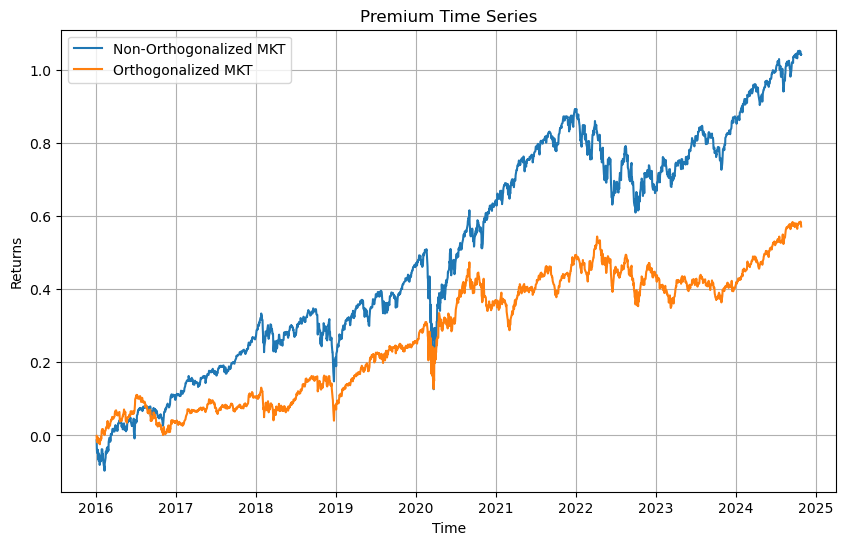

In [12]:
# Obtaining the Real MKT Premium

OMKT = results_mktvsamd.resid
regression_df['OMKT'] = OMKT

# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(regression_df['MKT'].cumsum(), label='Non-Orthogonalized MKT', alpha=1)
plt.plot(regression_df['OMKT'].cumsum(), label='Orthogonalized MKT', alpha=1)
# plt.plot(regression_df['BAB'].cumsum(), label='BAB Premium', alpha=1)

# Config
plt.title('Premium Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [13]:
# Create the X Matrix
x_alt = regression_df[['OMKT', 'SMB', 'HML', 'WML', 'BAB']]

x_alt.corr()

,OMKT,SMB,HML,WML,BAB
OMKT,1.000000,-0.182386,-0.131952,0.108821,0.003329
SMB,-0.182386,1.000000,0.341049,-0.509916,0.574578
HML,-0.131952,0.341049,1.000000,-0.570186,0.218026
WML,0.108821,-0.509916,-0.570186,1.000000,-0.426264
BAB,0.003329,0.574578,0.218026,-0.426264,1.000000


In [14]:
# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x_alt,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                             
Dep. Variable:     stock_excess_returns   R-squared:                       0.433
Model:                              WLS   Adj. R-squared:                  0.432
Method:                   Least Squares   F-statistic:                     335.1
Date:                  Tue, 22 Apr 2025   Prob (F-statistic):          3.15e-267
Time:                          13:32:46   Log-Likelihood:                 5462.5
No. Observations:                  2202   AIC:                        -1.091e+04
Df Residuals:                      2196   BIC:                        -1.088e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000

In [15]:
vif_data_alt = pd.DataFrame()
vif_data_alt['vars'] = x_alt.columns
vif_data_alt['VIF'] = [variance_inflation_factor(x_alt.values, i) for i in range(x_alt.shape[1])]

vif_data_alt

,vars,VIF
0,OMKT,1.061046
1,SMB,1.792368
2,HML,1.514850
3,WML,1.856133
4,BAB,1.580728


### Obtaining the Coefficients for a single stock ###

In [16]:
# Define the Function
def CarhartFactors(
    stock_returns: pd.Series, 
    market_returns: pd.Series = OMKT, 
    small_minus_big_series: pd.Series = SMB,
    high_minus_low_series: pd.Series = HML,
    winners_minus_losers_series: pd.Series = WML,
    aggressive_minus_defensive_series: pd.Series = BAB,
    window: int = 252
) -> pd.DataFrame:
    
    # Find common index
    common_index = stock_returns.index \
        .intersection(market_returns.index) \
        .intersection(small_minus_big_series.index) \
        .intersection(high_minus_low_series.index) \
        .intersection(winners_minus_losers_series.index) \
        .intersection(aggressive_minus_defensive_series.index)
    
    # Reindex
    stock_returns = stock_returns.loc[common_index]
    market_returns = market_returns.loc[common_index]
    small_minus_big_series = small_minus_big_series.loc[common_index]
    high_minus_low_series = high_minus_low_series.loc[common_index]
    winners_minus_losers_series = winners_minus_losers_series.loc[common_index]
    aggressive_minus_defensive_series = aggressive_minus_defensive_series.loc[common_index]
    
    # X Matrix
    X_all = pd.concat([
        market_returns,
        small_minus_big_series,
        high_minus_low_series,
        winners_minus_losers_series,
        aggressive_minus_defensive_series
    ], axis=1)
    
    # Create the Betas DataFrame
    betas = pd.DataFrame(
        index=stock_returns.index, 
        columns=[
            "mkt_beta", 
            "smb_beta", 
            "hml_beta", 
            "wml_beta", 
            "bab_beta"
        ], 
        dtype=float
    )
    
    # Rolling Regression
    for i in range(window, len(stock_returns)):
        
        # Data
        y_window = stock_returns.iloc[i-window:i]
        X_window = X_all.iloc[i-window:i]
        
        # Calculate the Regression
        weights = window * wexp(window, window/2)
        X_window = sm.add_constant(X_window)
        model = sm.WLS(y_window, X_window, weights=weights, missing='drop').fit()
        params = model.params

        # Store the betas
        mkt_beta = params.iloc[1]
        smb_beta = params.iloc[2]
        hml_beta = params.iloc[3]
        wml_beta = params.iloc[4]
        bab_beta = params.iloc[5]
        
        betas.iloc[i] = [
            mkt_beta,
            smb_beta,
            hml_beta,
            wml_beta,
            bab_beta
        ]
        
    return betas

In [17]:
# Check if the Function Works (Remember the Stock we are using)

parameters = CarhartFactors(
    regression_df['stock_excess_returns'],
).dropna()

parameters

,mkt_beta,smb_beta,hml_beta,wml_beta,bab_beta
Date,,,,,
2017-01-09,1.203721,-0.306363,-1.122342,-0.209010,0.711952
2017-01-10,1.192646,-0.324477,-1.142837,-0.219974,0.718170
2017-01-11,1.175753,-0.324564,-1.140058,-0.219564,0.706118
2017-01-12,1.178887,-0.309970,-1.133737,-0.199950,0.715873
2017-01-13,1.181364,-0.324157,-1.139456,-0.205347,0.714737
...,...,...,...,...,...
2024-10-21,1.313557,-0.082365,-0.225503,0.838641,0.719655
2024-10-22,1.312807,-0.086056,-0.218179,0.841549,0.718819
2024-10-23,1.309698,-0.157376,-0.208409,0.830443,0.722345


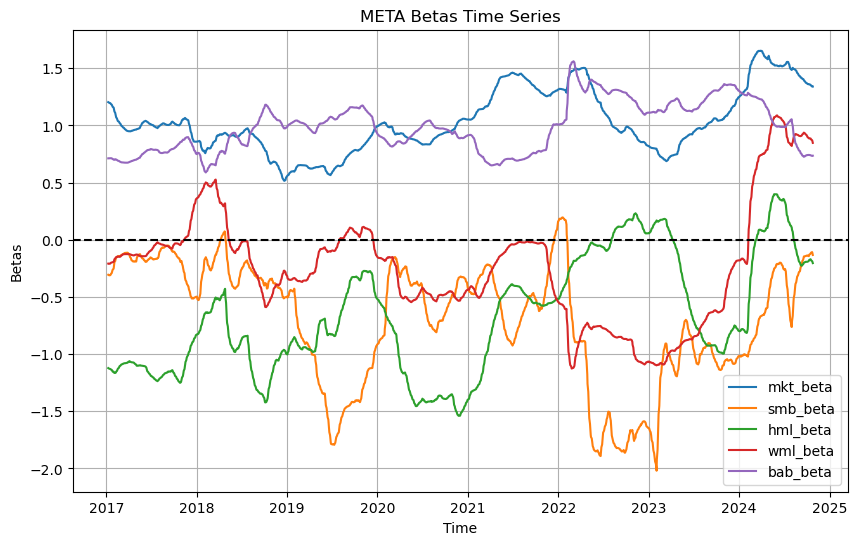

In [18]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(parameters.ewm(span=21, adjust = False).mean(), label=parameters.columns, alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title(f'{ticker} Betas Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()
plt.grid()

# Show
plt.show()

### Obtaining the Coefficients for all the Stocks ###

In [19]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = import_stock_universe(
    folder_path,
    ['Adjusted_close', 'Company Market Cap', 'Price_to_Book_inverse'],
    ['adj_close', 'mkt_cap', 'btp'],
)

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [21]:
# Create a whole new dataframe that contains all the stocks betas
rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Drop nans
returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [22]:
# Create Dicts
betas_mkt_dict = {}
betas_smb_dict = {}
betas_hml_dict = {}
betas_wml_dict = {}
betas_bab_dict = {}

# Loop
for ticker, df in dataframes.items():
    stock_returns = returns_df[ticker]

    # Calculate betas
    parameters = CarhartFactors(stock_returns)

    # Store
    betas_mkt_dict[ticker] = parameters['mkt_beta']
    betas_smb_dict[ticker] = parameters['smb_beta']
    betas_hml_dict[ticker] = parameters['hml_beta']
    betas_wml_dict[ticker] = parameters['wml_beta']
    betas_bab_dict[ticker] = parameters['bab_beta']

    print(f'{ticker} is ready.')

# Create the DataFrames
betas_mkt = pd.concat(betas_mkt_dict, axis=1)
betas_smb = pd.concat(betas_smb_dict, axis=1)
betas_hml = pd.concat(betas_hml_dict, axis=1)
betas_wml = pd.concat(betas_wml_dict, axis=1)
betas_amd = pd.concat(betas_bab_dict, axis=1)

A is ready.
AAPL is ready.
ABBV is ready.
ABT is ready.
ADBE is ready.
ADI is ready.
ADM is ready.
ADP is ready.
ADSK is ready.
AEE is ready.
AEP is ready.
AES is ready.
AFL is ready.
AIG is ready.
AIZ is ready.
AJG is ready.
AKAM is ready.
ALB is ready.
ALGN is ready.
ALL is ready.
AMAT is ready.
AMD is ready.
AME is ready.
AMGN is ready.
AMP is ready.
AMT is ready.
AMZN is ready.
ANET is ready.
ANSS is ready.
AOS is ready.
APA is ready.
APD is ready.
APH is ready.
APO is ready.
ARE is ready.
AWK is ready.
BALL is ready.
BDX is ready.
BK is ready.
BKNG is ready.
BLDR is ready.
BMY is ready.
BR is ready.
BRO is ready.
BSX is ready.
BWA is ready.
BX is ready.
BXP is ready.
C is ready.
CAG is ready.
CAH is ready.
CBRE is ready.
CCI is ready.
CDNS is ready.
CDW is ready.
CE is ready.
CF is ready.
CFG is ready.
CHD is ready.
CHRW is ready.
CHTR is ready.
CI is ready.
CINF is ready.
CL is ready.
CLX is ready.
CMCSA is ready.
CME is ready.
CMG is ready.
CMI is ready.
CMS is ready.
CNC is rea

In [23]:
# See Market Betas
betas_mkt.dropna(inplace = True)

betas_mkt

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.053028,1.030754,0.771590,1.016650,1.339633,1.030549,0.988914,1.086617,1.394942,1.337559,...,0.932398,1.397838,0.719240,1.302553,0.878903,0.895989,1.142860,0.989166,0.719007,0.826312
2017-01-10,1.053705,1.017768,0.769145,1.018644,1.337241,1.018460,0.976391,1.090438,1.393977,1.349206,...,0.931976,1.380373,0.714713,1.307635,0.893765,0.894628,1.136737,0.964672,0.716423,0.837360
2017-01-11,1.049109,0.998723,0.789134,1.012014,1.349150,1.020330,0.983307,1.084524,1.383848,1.355290,...,0.926430,1.384412,0.646759,1.314163,0.905523,0.901150,1.124665,0.917571,0.720412,0.831009
2017-01-12,1.051910,1.005032,0.780942,1.008626,1.349570,1.022199,0.984584,1.085237,1.385792,1.353644,...,0.925692,1.386660,0.634109,1.311353,0.900943,0.902470,1.123105,0.920977,0.725322,0.828890
2017-01-13,1.056916,1.001810,0.793093,1.008482,1.345029,1.013558,0.982914,1.084562,1.382141,1.354084,...,0.927163,1.387384,0.637412,1.309831,0.905516,0.904078,1.123667,0.926933,0.723441,0.840485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21,0.752097,1.092776,1.086429,0.800832,1.121925,0.920447,0.935999,0.774359,0.979697,1.183146,...,0.584397,0.817873,0.710760,1.050837,0.567689,1.020973,0.754136,1.145750,0.470469,0.983576
2024-10-22,0.754897,1.092136,1.093643,0.827655,1.121751,0.933702,0.934640,0.777135,0.985563,1.186211,...,0.589698,0.830983,0.707869,1.054343,0.569712,1.022879,0.763933,1.152154,0.475452,0.990116
2024-10-23,0.766261,1.093957,1.082636,0.829452,1.121204,0.932554,0.936003,0.774446,0.982403,1.185796,...,0.586691,0.833837,0.720289,1.055089,0.573036,1.039954,0.765179,1.151394,0.474406,0.989406


In [24]:
# See SMB Betas
betas_smb.dropna(inplace = True)

betas_smb

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,0.604406,-0.378415,-0.705636,0.005359,0.495427,0.731285,0.842149,0.089337,1.635160,1.192544,...,1.031959,1.369493,0.345952,1.071218,-0.696978,0.938761,0.202377,0.043284,1.520959,-0.712875
2017-01-10,0.601667,-0.396088,-0.711117,0.007408,0.492373,0.717659,0.822535,0.095552,1.631740,1.208582,...,1.028992,1.342722,0.344169,1.077199,-0.675885,0.936398,0.191743,0.003250,1.519574,-0.697564
2017-01-11,0.582730,-0.369792,-0.728922,0.063681,0.472985,0.722641,0.789962,0.091247,1.620332,1.215518,...,1.052476,1.300232,0.457651,1.088394,-0.721210,0.887513,0.225213,0.276548,1.442156,-0.689818
2017-01-12,0.603511,-0.363861,-0.782674,0.055176,0.478628,0.721837,0.775895,0.099852,1.624158,1.221391,...,1.026049,1.304991,0.431313,1.101486,-0.712336,0.885648,0.214878,0.284401,1.424962,-0.704524
2017-01-13,0.584042,-0.343675,-0.846444,0.059490,0.504433,0.767809,0.792553,0.100324,1.641885,1.224479,...,1.018307,1.307605,0.420768,1.109703,-0.734141,0.885836,0.211255,0.254844,1.438332,-0.764090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21,1.389123,-0.335569,0.280874,0.334043,-2.388715,-0.599766,0.204355,0.036687,0.327695,1.246146,...,1.015792,2.241955,0.548901,0.783206,-0.134293,1.158687,0.704677,0.492003,1.057701,0.980232
2024-10-22,1.384357,-0.333985,0.286483,0.366701,-2.386490,-0.582815,0.204572,0.038473,0.330763,1.249859,...,1.012369,2.252775,0.538782,0.785367,-0.125022,1.155099,0.719412,0.499214,1.063606,0.977896
2024-10-23,1.481226,-0.320008,0.209909,0.410035,-2.304437,-0.579571,0.256357,0.029535,0.322498,1.276745,...,0.973507,2.307318,0.485541,0.771661,-0.111599,1.207234,0.720460,0.534649,1.029348,0.937221


In [25]:
# See HML Betas
betas_hml.dropna(inplace = True)

betas_hml

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,-0.553512,-0.775790,-0.589885,-0.526155,-1.143369,-0.593917,0.819222,-0.178859,-0.977114,0.572912,...,-0.654085,0.194228,-0.883158,0.370532,0.779795,0.307265,-0.251864,-0.490906,-0.125936,-0.785447
2017-01-10,-0.549825,-0.802080,-0.593474,-0.521696,-1.148340,-0.620176,0.795495,-0.171767,-0.977733,0.596371,...,-0.653428,0.160770,-0.895092,0.381411,0.809333,0.304833,-0.262802,-0.536253,-0.132517,-0.763258
2017-01-11,-0.548611,-0.799587,-0.596328,-0.521971,-1.149828,-0.620604,0.795148,-0.170690,-0.975792,0.595202,...,-0.653086,0.161136,-0.886673,0.380066,0.808499,0.304946,-0.261629,-0.535137,-0.131295,-0.762401
2017-01-12,-0.539240,-0.798136,-0.620354,-0.525308,-1.147208,-0.621406,0.788100,-0.166711,-0.974384,0.598392,...,-0.665629,0.162925,-0.896528,0.386986,0.813783,0.303756,-0.266252,-0.532117,-0.140653,-0.769002
2017-01-13,-0.535800,-0.787869,-0.638927,-0.519287,-1.137044,-0.607180,0.803522,-0.170684,-0.971140,0.606524,...,-0.667914,0.172277,-0.890505,0.389689,0.810367,0.315364,-0.268206,-0.538447,-0.132077,-0.784624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21,-0.442495,-0.631752,0.009284,-0.261515,-0.924634,-0.236860,0.684309,-0.170966,-0.286317,0.442948,...,-0.308608,0.371050,-0.087847,0.271307,1.086998,0.112882,-0.500153,0.072362,0.348803,-0.641689
2024-10-22,-0.411094,-0.640495,0.033508,-0.208828,-0.932692,-0.213395,0.675707,-0.160460,-0.261890,0.449027,...,-0.266908,0.413090,-0.072623,0.284876,1.069406,0.135348,-0.489801,0.086799,0.359101,-0.596215
2024-10-23,-0.415964,-0.640985,0.034978,-0.214872,-0.948782,-0.215355,0.667562,-0.161941,-0.264049,0.443477,...,-0.263129,0.406179,-0.047995,0.288333,1.070788,0.145613,-0.488533,0.079235,0.364320,-0.589393


In [26]:
# See WML Betas

betas_wml.dropna(inplace = True)

betas_wml

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,0.049430,-0.357087,-0.085431,-0.106868,-0.265295,-0.116835,-0.323685,-0.091241,-0.053569,0.037300,...,0.056892,-0.076346,-0.498985,0.041567,0.027108,0.460020,-0.236009,-0.145303,0.234443,-0.192351
2017-01-10,0.035640,-0.356529,-0.093422,-0.109453,-0.264432,-0.105699,-0.332812,-0.087586,-0.061451,0.037508,...,0.047919,-0.086886,-0.482336,0.037838,0.029736,0.458160,-0.244399,-0.169441,0.242570,-0.191783
2017-01-11,0.028492,-0.345936,-0.100780,-0.087679,-0.272186,-0.103835,-0.345496,-0.089083,-0.065564,0.040011,...,0.057079,-0.103301,-0.436994,0.041964,0.012030,0.439224,-0.231235,-0.063302,0.212749,-0.188643
2017-01-12,0.055475,-0.335098,-0.171112,-0.099998,-0.265054,-0.103754,-0.361954,-0.078164,-0.059782,0.046248,...,0.024373,-0.096207,-0.476373,0.056358,0.020264,0.437698,-0.244749,-0.051770,0.194540,-0.207816
2017-01-13,0.083105,-0.320812,-0.173226,-0.085069,-0.255979,-0.099632,-0.328599,-0.090906,-0.065152,0.068796,...,0.024024,-0.069462,-0.448500,0.057593,0.028648,0.473560,-0.247658,-0.045677,0.209516,-0.204433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21,-0.557189,-0.444506,-0.239483,-0.289392,-0.780096,-0.786456,-0.491959,-0.337870,-0.159139,-0.096636,...,-0.148663,-0.222483,-0.872960,-0.444929,-0.030562,0.241187,-0.473170,-0.531448,-0.299969,-0.611776
2024-10-22,-0.544983,-0.447911,-0.230285,-0.269869,-0.783252,-0.777818,-0.495277,-0.333866,-0.149803,-0.094383,...,-0.132523,-0.206547,-0.866859,-0.439754,-0.037555,0.249923,-0.469530,-0.526057,-0.296142,-0.594208
2024-10-23,-0.526570,-0.445169,-0.245784,-0.263164,-0.772397,-0.777914,-0.487629,-0.336329,-0.152395,-0.090936,...,-0.139186,-0.197832,-0.868280,-0.441263,-0.034189,0.264939,-0.468808,-0.521614,-0.301268,-0.600046


In [27]:
# See AMD Betas
betas_amd.dropna(inplace = True)

betas_amd

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,0.974633,0.551251,0.880856,0.786389,0.730321,0.797955,0.328642,0.445538,1.254820,-0.514338,...,0.476266,0.527135,1.003185,-0.551968,0.514213,0.710510,0.526920,0.635893,1.195835,0.792117
2017-01-10,0.978144,0.554933,0.883728,0.786496,0.730795,0.798526,0.334794,0.443426,1.257225,-0.517832,...,0.478805,0.535125,1.000041,-0.552464,0.509120,0.711412,0.530985,0.649617,1.194411,0.788704
2017-01-11,0.971819,0.545595,0.895106,0.790832,0.736160,0.800660,0.334478,0.438518,1.248170,-0.512379,...,0.478634,0.531162,0.969888,-0.546009,0.510200,0.708188,0.527771,0.660058,1.184788,0.785425
2017-01-12,0.984348,0.553686,0.861923,0.783868,0.739282,0.801795,0.328598,0.443340,1.251647,-0.510836,...,0.465016,0.535348,0.946552,-0.541865,0.510818,0.708352,0.521403,0.666716,1.180344,0.776447
2017-01-13,1.000445,0.558632,0.867977,0.790910,0.740975,0.798740,0.343547,0.436866,1.246962,-0.499818,...,0.465704,0.548533,0.961776,-0.542160,0.517477,0.726403,0.520342,0.673086,1.186399,0.784802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21,0.553536,0.587889,-0.093551,-0.094755,0.767704,1.480907,0.308842,0.141162,0.850900,-0.255360,...,0.373600,0.331833,0.803065,-0.179009,0.183418,0.566576,0.131839,0.255223,1.086974,0.277113
2024-10-22,0.554019,0.587849,-0.089764,-0.078997,0.767948,1.488810,0.308309,0.142566,0.853767,-0.253562,...,0.375310,0.338804,0.800428,-0.177248,0.185574,0.566855,0.137993,0.258902,1.089878,0.279491
2024-10-23,0.550930,0.587446,-0.087804,-0.081161,0.762910,1.488343,0.305536,0.142461,0.853509,-0.255269,...,0.376918,0.336221,0.806568,-0.176251,0.185562,0.567801,0.138227,0.256602,1.091678,0.281755


In [28]:
# Save

betas_mkt.to_csv(r'..\additional_data\carhart_market_betas.csv')
betas_smb.to_csv(r'..\additional_data\carhart_size_betas.csv')
betas_hml.to_csv(r'..\additional_data\carhart_value_betas.csv')
betas_wml.to_csv(r'..\additional_data\carhart_mom_betas.csv')
betas_amd.to_csv(r'..\additional_data\carhart_beta_betas.csv')